In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

In [10]:
targetDir = "../data/output/d4/Result/"
speedDir = "../data/output/d4/Speed/"
brakeDir = "../data/output/d4/Brake/"
accelDIr = "../data/output/d4/Accel/"
steeringPositiveDir = "../data/output/d4/SteeringPositive/"
steeringNegativeDir = "../data/output/d4/SteeringNegative/"
aheadDistance = "../data/output/d4/AheadDistance/"

In [11]:
df1 = pd.read_csv(speedDir + "result.csv")
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(aheadDistance + "result.csv")
df6.columns = [["id", "near", "intermediate", "far"]]

In [12]:
df = pd.merge(pd.merge(pd.merge(pd.merge(df1, df2, on="id"), df3, on="id"), df4, on="id"), df5, on="id")
df = pd.merge(df, df6, on="id")
gridSize = len(df)

In [13]:
features =  ["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far"]

In [99]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['stop'] > 0]
mf = mf[["red", "yellow", "green", "stop", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far"]]
mf.columns = features

In [100]:
mf.describe()

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,31.973384,89.064639,58.361217,109.110266,5.000000,6.087452,27.414449,12.775665,167.262357,78.669202,42.577947
std,44.534694,89.638330,88.349080,215.273675,7.141963,7.559178,71.240798,44.379856,242.651911,94.552708,35.127692
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,9.000000,15.000000
50%,3.000000,69.000000,12.000000,0.000000,2.000000,3.000000,0.000000,0.000000,69.000000,39.000000,39.000000
75%,60.000000,151.500000,87.000000,117.000000,8.000000,9.000000,12.000000,0.000000,206.000000,123.500000,64.500000
max,174.000000,489.000000,441.000000,1341.000000,43.000000,53.000000,492.000000,330.000000,1476.000000,486.000000,233.000000


In [107]:
colors = [
    "#FE2400",
    "#EC2127",
    "#D21E4E",
    "#B21D72",
    "#951E93",
    "#7421B1",
    "#5023D0",
    "#3025EA",
    "#082EFD",
    "#1147CE",
    "#247395",
    "#389D51",
    "#49C900",
    "#81D503",
    "#AFE400",
    "#DAF201",
    "#FFFF01",
    "#FEE600",
    "#FECD02",
    "#FEAF07",
    "#FF9400",
    "#FE7701",
    "#FD5800",
    "#FF3900",
]

names = [
    "Red",
    "Carmine",
    "CardinaL",
    "Violet",
    "Magenta",
    "Purple",
    "Azure",
    "Ultramarine",
    "Blue",
    "Teal",
    "Turquoise",
    "Pine",
    "Green",
    "Chartreuse",
    "Olieve",
    "Khaki",
    "Yellow",
    "Mustard",
    "Fulvous",
    "Apricot",
    "Orange",
    "Tangerine",
    "Titan",
    "Cerise"
]

# VBGMM

In [25]:
speeds = ["red", "yellow", "green", "slow"]
pedals = ["brake", "accel"]
steerings = ["steeringPositive", "steeringNegative"]
distances = ["near", "intermediate", "far"]

In [101]:
bf = mf.copy()
bf["sumSpeed"] = bf["red"] + bf["yellow"] + bf["green"] + bf["slow"]
bf["sumPedal"] = bf["brake"] + bf["accel"] 
bf["sumSteering"] = bf["steeringPositive"] + bf["steeringNegative"]
bf["sumDistance"] = bf["near"] + bf["intermediate"] + bf["far"]

for key in speeds:
    bf[key] = bf[key] / bf["sumSpeed"]
    
for key in pedals:
    bf[key] = bf[key] / bf["sumPedal"]
    
for key in steerings:
    bf[key] = bf[key] / bf["sumSteering"]

for key in distances:
    bf[key] = bf[key] / bf["sumDistance"]

bf = bf.fillna(0)    
    
bf = bf[features]

In [84]:
components = 24
prior = 0.0001
cov_type = 'full'
cov_prior = 0.1 * np.identity(len(features))
max_iter = 200

In [85]:
def gridSearch():
    result = []
    for k in range(20):
        sd = k
        np.random.seed(sd)
        random.seed(sd)
    
        vb = BayesianGaussianMixture(
            n_components=components,
            weight_concentration_prior=prior, 
            covariance_type=cov_type,
            covariance_prior=cov_prior,
            max_iter=max_iter
        ).fit(bf)
        result.append({
                "seed": sd,
                "classes": len(set(vb.predict(bf))),
                "lower bounds": vb.lower_bound_
        })

    return sorted(result, key=lambda res: res["lower bounds"])

pprint.pprint(gridSearch())

[{'classes': 20, 'lower bounds': 8719.6122385816489, 'seed': 16},
 {'classes': 20, 'lower bounds': 8785.1325137433814, 'seed': 14},
 {'classes': 19, 'lower bounds': 8884.0626358757381, 'seed': 5},
 {'classes': 19, 'lower bounds': 8950.4502432042827, 'seed': 7},
 {'classes': 19, 'lower bounds': 8977.1089047833648, 'seed': 18},
 {'classes': 16, 'lower bounds': 9003.9839920502291, 'seed': 1},
 {'classes': 18, 'lower bounds': 9006.4793823225409, 'seed': 19},
 {'classes': 15, 'lower bounds': 9016.2829976165776, 'seed': 0},
 {'classes': 17, 'lower bounds': 9020.2245325149561, 'seed': 2},
 {'classes': 14, 'lower bounds': 9022.671354611577, 'seed': 11},
 {'classes': 19, 'lower bounds': 9031.9827141732767, 'seed': 15},
 {'classes': 14, 'lower bounds': 9036.5366858610014, 'seed': 13},
 {'classes': 15, 'lower bounds': 9039.194347841827, 'seed': 10},
 {'classes': 16, 'lower bounds': 9044.5804887991617, 'seed': 6},
 {'classes': 17, 'lower bounds': 9058.5103347595214, 'seed': 8},
 {'classes': 16, 'l

In [90]:
sd = 16
np.random.seed(sd)
random.seed(sd)

In [103]:
vb = BayesianGaussianMixture(
    n_components=components,
    weight_concentration_prior=prior, 
    covariance_type=cov_type,
    covariance_prior=cov_prior,
    max_iter=max_iter    
).fit(bf)
print "class size:      ", len(set(vb.predict(bf)))
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

class size:       18
classes:           set([1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 15, 17, 18, 19, 20, 21, 23])
lower bound:  9050.71939161


In [92]:
vb.weights_

array([ 0.00378788,  0.15471307,  0.03361268,  0.05225259,  0.04533277,
        0.01850747,  0.05491272,  0.01081402,  0.29168644,  0.01080051,
        0.00356055,  0.0283029 ,  0.02778532,  0.10655303,  0.01680703,
        0.00984056,  0.03841821,  0.00618914,  0.00298723,  0.00288362,
        0.03597529,  0.0311821 ,  0.00873402,  0.00436087])

In [102]:
ref = pd.DataFrame(vb.means_)
ref.columns = [features]
ref

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far
0,0.328503,0.341916,0.133305,0.196276,0.288222,0.498850,0.293826,0.132030,0.470197,0.244916,0.284888
1,0.982718,0.009243,0.003251,0.004787,0.055811,0.012167,0.007167,0.003220,0.365737,0.070865,0.563398
2,0.078895,0.729064,0.077874,0.114167,0.125883,0.850319,0.032839,0.014756,0.535652,0.218404,0.245945
3,0.517223,0.436890,0.031822,0.014066,0.159030,0.825733,0.056857,0.045279,0.150352,0.245822,0.603825
4,0.067327,0.341759,0.289696,0.301217,0.605978,0.376545,0.024117,0.010837,0.379453,0.429177,0.191370
5,0.278330,0.650876,0.031539,0.039255,0.277381,0.680033,0.858765,0.026406,0.629509,0.165652,0.204839
6,0.044159,0.180835,0.203000,0.572007,0.364477,0.621246,0.066387,0.895118,0.715171,0.208364,0.076464
7,0.180276,0.274943,0.340189,0.204592,0.266619,0.661303,0.760954,0.044693,0.268232,0.457953,0.273815
8,0.008102,0.397196,0.230227,0.364476,0.445390,0.551953,0.855173,0.137664,0.622818,0.293758,0.083424
9,0.109501,0.780639,0.044435,0.065425,0.096074,0.166283,0.097942,0.044010,0.793096,0.081639,0.125266


# Plot histgram of each clusters

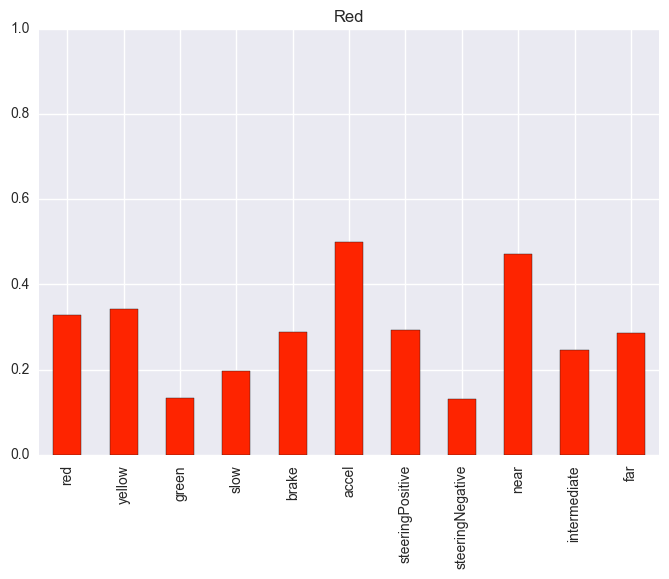

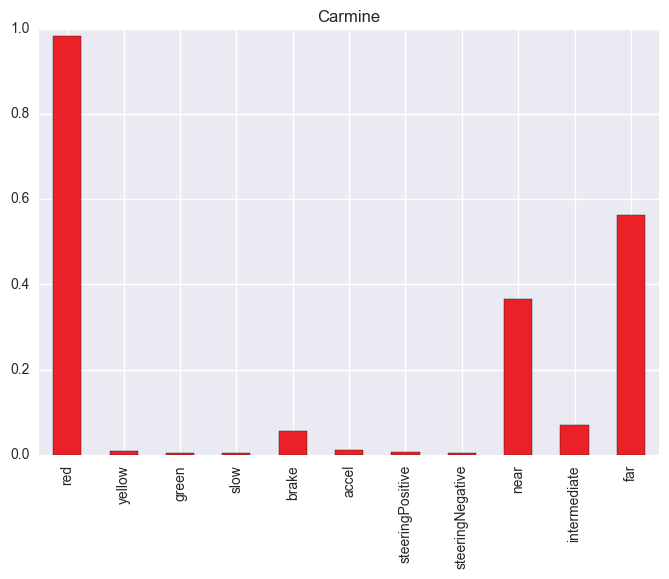

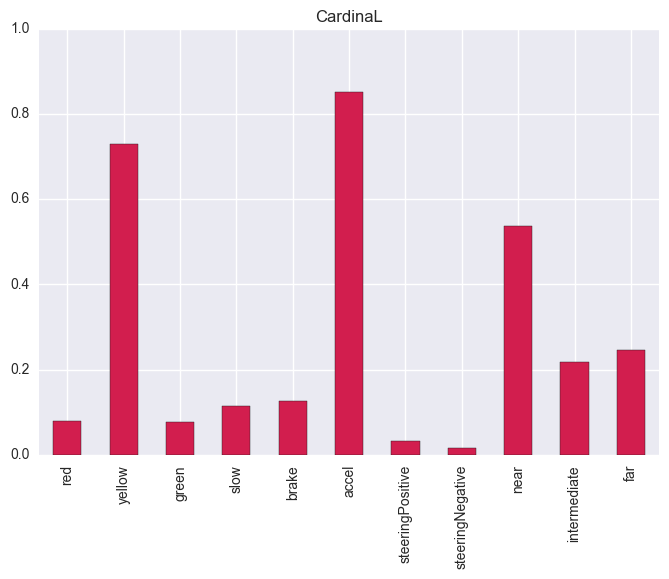

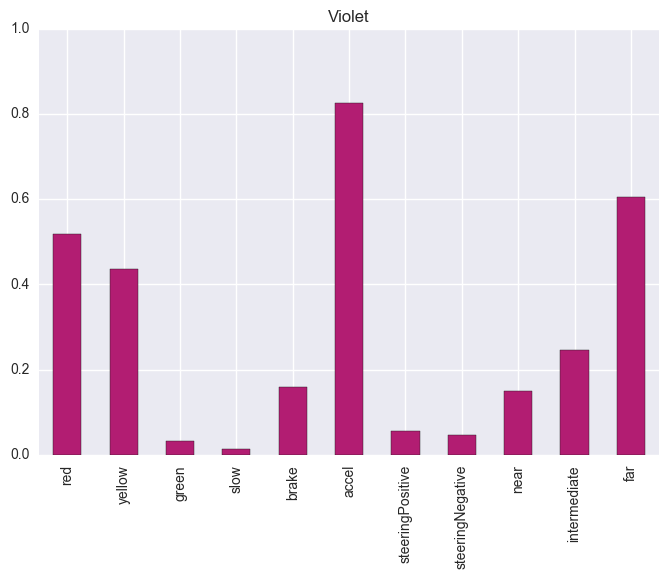

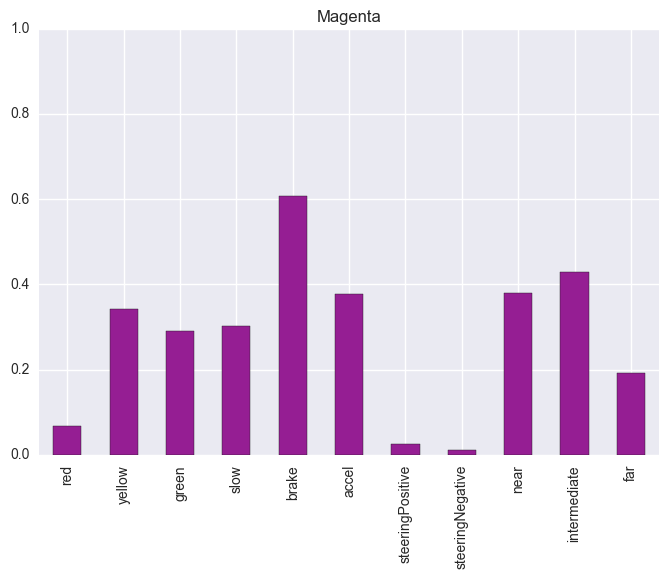

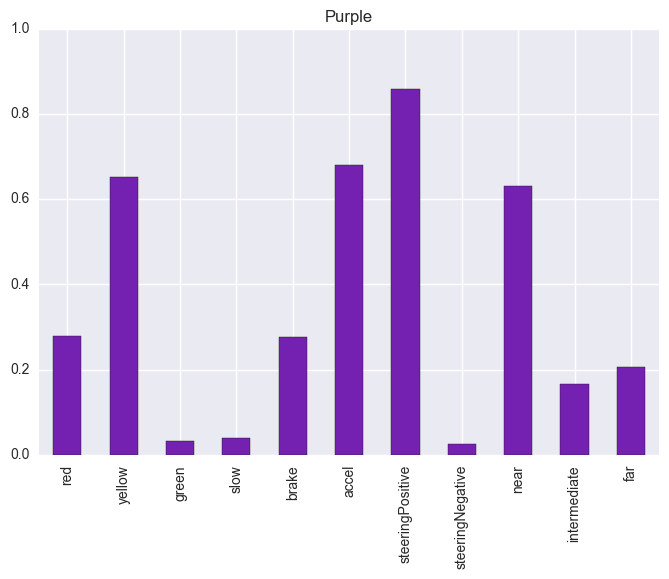

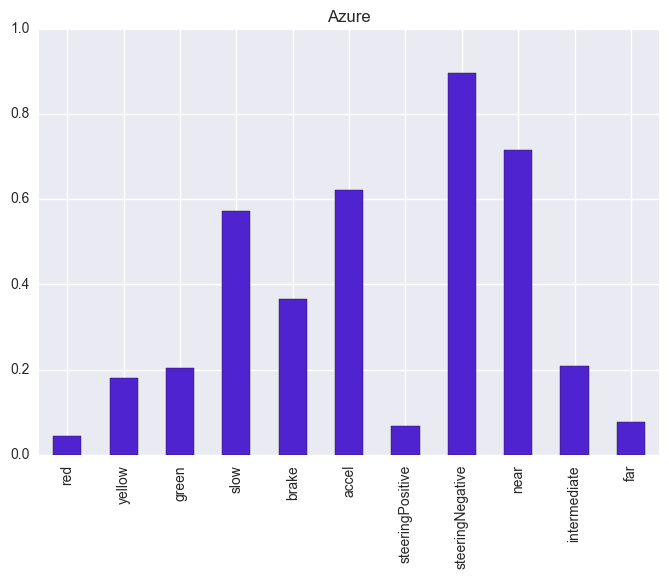

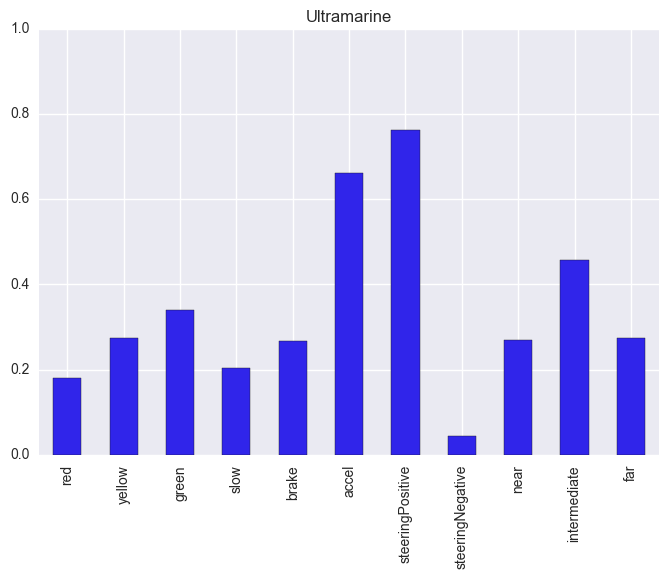

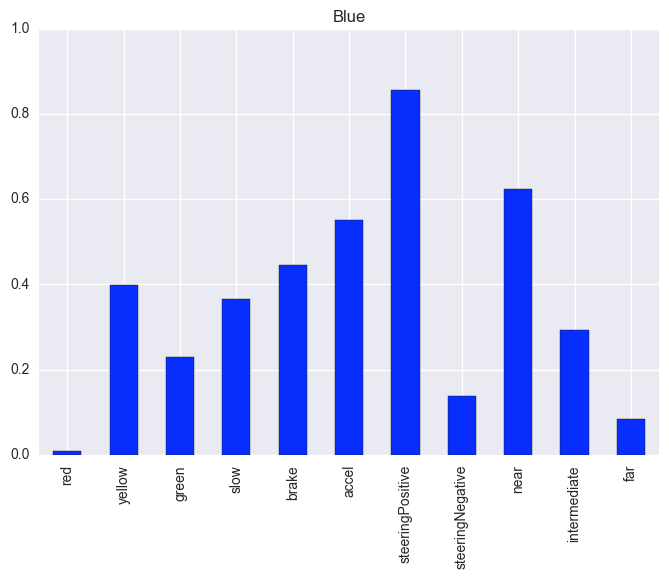

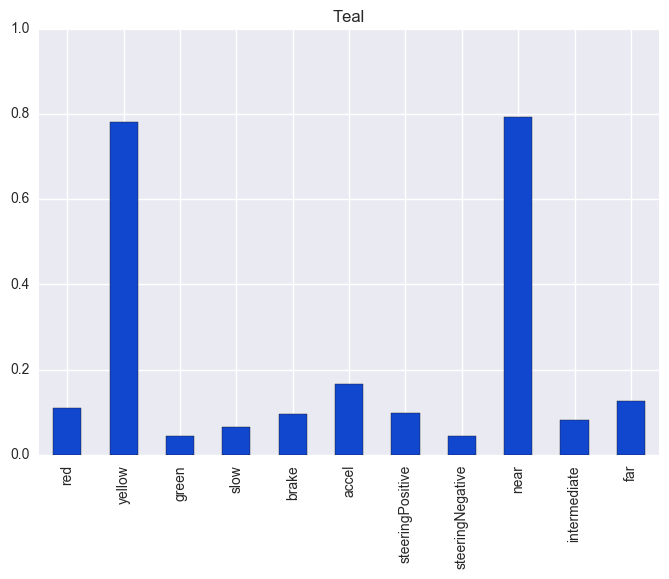

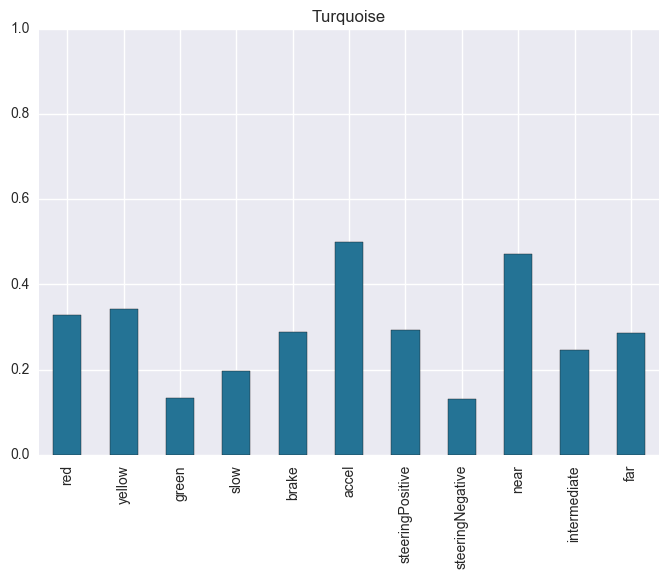

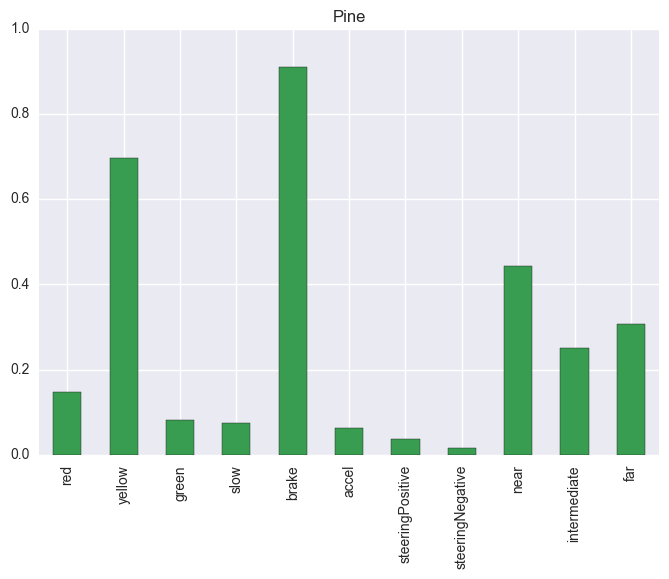

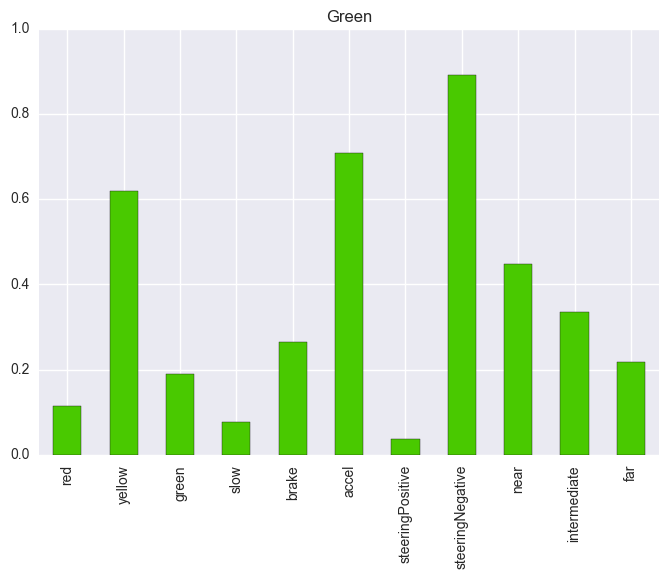

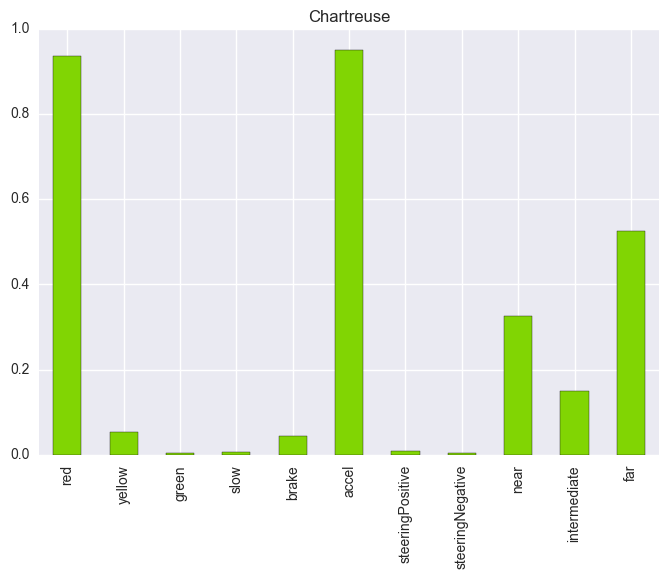

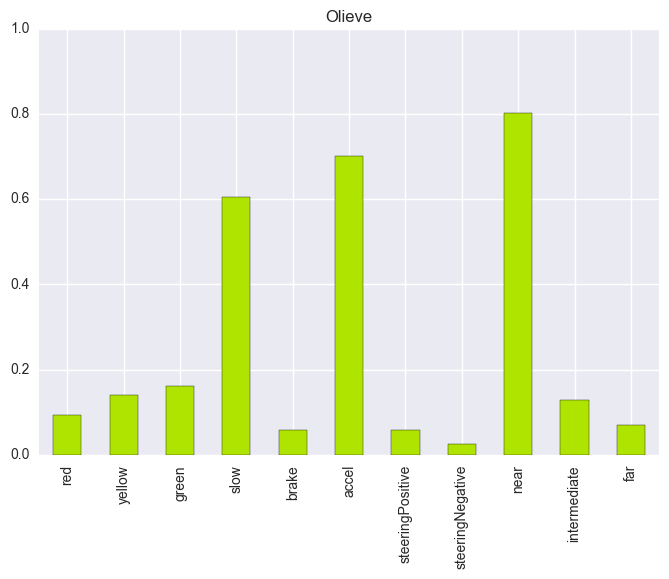

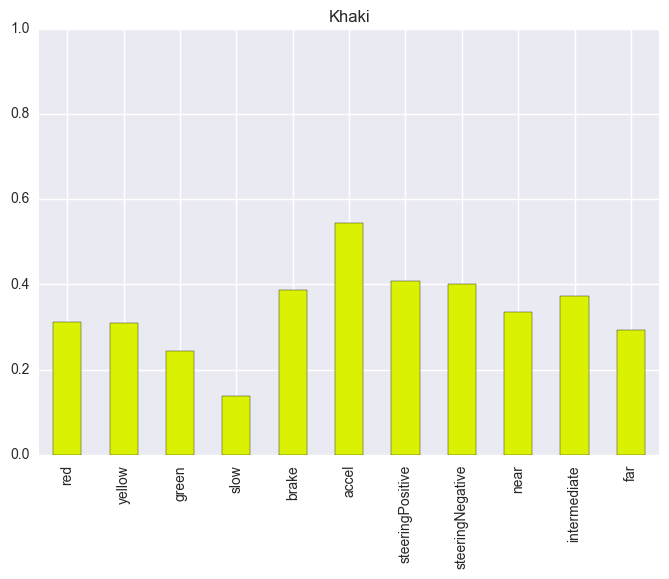

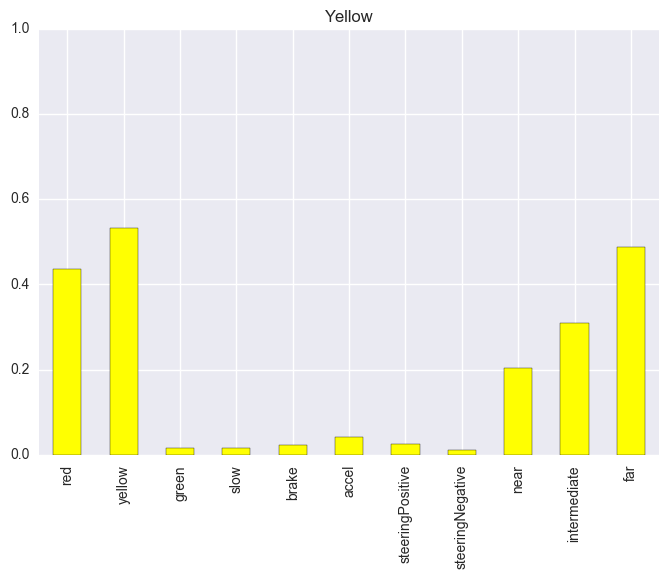

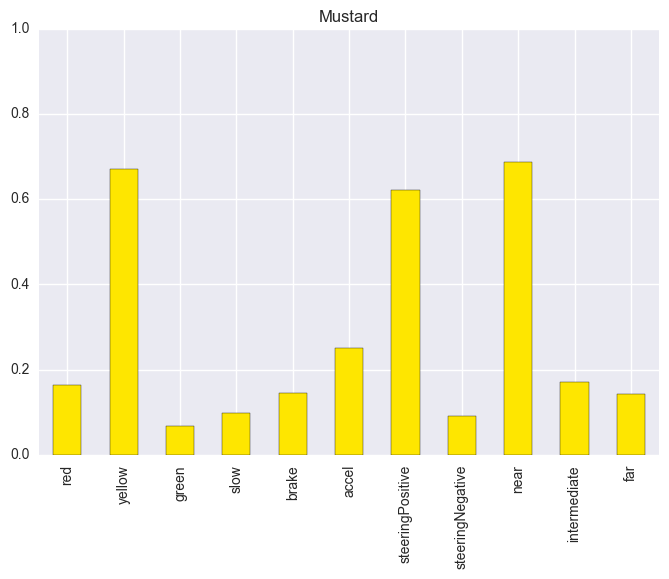

In [108]:
dir = "./img/d4/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)
    
resLength = len(set(vb.predict(bf)))
for i in range(resLength):
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.title(names[i])
    plt.ylim(0, 1)
    plt.savefig(dir + "/cluster" + str(i) + ".png")
    plt.show()

# Save

In [110]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")

with open(dir + '/VBSetting.json', 'w') as outfile:
    data = {
        "n_components": components,
        "weight_concentration_prior": prior,
        "seed": sd
    }
    json.dump(data, outfile)